# Autoencoders y Modelos Generativos

In [21]:
import torch 
import torch.utils
import torch.distributions
import torchvision
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from typing import Tuple, Dict, List

# 1.0 Autoencoder

Un autoencoder es un tipo de red neuronal que se utiliza principalmente para realizar tareas de **reducción de dimensionalidad** y **reconstrucción de datos**.

La idea principal detrás de un autoencoder es aprender una **representación compacta** de los datos, de manera que la información esencial se mantenga, mientras que la información redundante o ruido se elimine. Un autoencoder consta de dos partes principales: 
1. El codificador (encoder)
2. El decodificador (decoder)

<img src="imagenes/autoencoder.png" width="80%"/> 

## 1.1 Construcción del Codificador
El **codificador** toma los datos de entrada y los transforma en una representación de dimensionalidad reducida, llamada **código latente**. 

La transformación realizada por el codificador puede expresarse matemáticamente como:

$\mathbf{h} = f(\mathbf{W} \mathbf{x}  + \mathbf{b} )$

Donde:
- $\mathbf{x}$ representa el vector de entrada.
- $\mathbf{W}$ es la matriz de pesos que se aplica a la entrada.
- $\mathbf{b}$ es el vector de sesgos.
- $f$ es la función de activación, como por ejemplo la función sigmoide o la función ReLU.


In [22]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()

        self.encode = nn.Sequential(
                            nn.Linear(784, 512),
                            nn.ReLU(),
                            nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.ReLU(),
                            nn.Linear(128, latent_dims),

                        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.encode(x)

## 1.2 Construcción del Decodificador

El **decodificador**, por otro lado, toma este código latente y lo transforma de nuevo en una versión reconstruida de los datos originales.

La transformación realizada por el decodificador puede expresarse matemáticamente como:

$\hat{\mathbf{x}} = g(\mathbf{W'}\mathbf{h} + \mathbf{b'})$

Donde:
- $\mathbf{h}$ es el código latente generado por el codificador.
- $\mathbf{W'}$ es la matriz de pesos del decodificador.
- $\mathbf{b'}$ es el vector de sesgos del decodificador.
- $\hat{\mathbf{x}}$ es la salida reconstruida, que idealmente será muy similar a la entrada original $\mathbf{x}$.


In [23]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
                            nn.Linear(latent_dims, 128),
                            nn.ReLU(),
                            nn.Linear(128, 256),
                            nn.ReLU(),
                            nn.Linear(256, 512),
                            nn.ReLU(),
                            nn.Linear(512, 784),
                            nn.Sigmoid(),
        )

    def forward(self, z):
        z = self.decode(z)
        return z.reshape((-1, 1, 28, 28))


In [24]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


## 1.3 Entrenamiento

### La Función de Pérdida

Para entrenar el autoencoder, se utiliza una función de pérdida que mide la diferencia entre la entrada original y la salida reconstruida. Una función de pérdida comúnmente utilizada es el error cuadrático medio (MSE, por sus siglas en inglés).

### El proceso de optimización

El objetivo del entrenamiento es minimizar la función de pérdida ajustando los pesos $\mathbf{W}$ y sesgos $\mathbf{b}$ de las capas. Esto se hace mediante técnicas de optimización como el descenso de gradiente.

In [25]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer):
    """
    Realiza un paso de entrenamiento para el modelo.

    Parámetros:
        - model (torch.nn.Module): El modelo a entrenar.
        - dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de entrenamiento.
        - optimizer (torch.optim.Optimizer): Optimizador para el modelo.

    Returns:
        - float: Pérdida promedio en el conjunto de datos de entrenamiento.
    """
    # Coloca el modelo en modo de entrenamiento
    model.train()
    
    # Inicializa la pérdida de entrenamiento
    train_loss = 0
    
    # Itera a través de los lotes de datos en el DataLoader
    for batch, data in enumerate(dataloader):
            
        # Envía los datos al dispositivo objetivo
        image = data[0]

        x = image.to(device)
        
        # 1. Realiza el pase hacia adelante
        x_hat = model(x)

        # 2. Calcula y acumula la pérdida
        loss = ((x - x_hat)**2).sum()
        train_loss += loss.item()

        # 3. Reinicia los gradientes del optimizador
        optimizer.zero_grad()

        # 4. Retropropagación de la pérdida
        loss.backward()

        # 5. Actualiza los pesos del modelo
        optimizer.step()

    # Ajusta las métricas para obtener la pérdida y precisión promedio por lote 
    train_loss = train_loss / dataloader.__len__()
    return train_loss

In [26]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader
             ):
    """
    Realiza un paso de evaluación para el modelo.

    Parámetros:
        - model (torch.nn.Module): El modelo a evaluar.
        - dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de prueba.

    Returns:
        - float: Pérdida promedio en el conjunto de datos de prueba.
    """
    # Pone el modelo en modo de evaluación
    model.eval() 
    
    # Inicializa la pérdida de prueba
    test_loss= 0
    
    # Activa el contexto de inferencia
    with torch.inference_mode():
        
        # Itera a través de los lotes de datos en el DataLoader
        for batch, data in enumerate(dataloader):
            
            # Envía los datos al dispositivo objetivo
            image = data[0]
        
            x = image.to(device)
            
            # 1. Realiza el pase hacia adelante
            x_hat = model(x)
        
            # 2. Calcula y acumula la pérdida
            loss = ((x - x_hat)**2).sum()
            test_loss += loss.item()
            
    # Ajusta las métricas para obtener la pérdida promedio por lote 
    
    test_loss = test_loss / dataloader.__len__()
    return test_loss

In [27]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          epochs: int = 20,
          verbose=False):
    """
    Entrena un modelo durante un número especificado de épocas.

    Parámetros:
        - model (torch.nn.Module): El modelo a entrenar.
        - train_dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de entrenamiento.
        - test_dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de prueba.
        - optimizer (torch.optim.Optimizer): Optimizador para el modelo.
        - epochs (int, opcional): Número de épocas de entrenamiento. Default es 20.
        - verbose (bool, opcional): Si True, imprime información sobre el progreso del entrenamiento. Default es False.

    Returns:
        - dict: Diccionario con las pérdidas de entrenamiento y prueba en cada época.
    """
    # 2. Crear un diccionario de resultados vacío
    results = {"train_loss": [],
               "test_loss": [],
              }
    
    # 3. Iterar a través de los pasos de entrenamiento y prueba durante un número de épocas
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                optimizer=optimizer)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader)
        
        # 4. Imprimir lo que está sucediendo
        if verbose:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.3f} | "
                f"test_loss: {test_loss:.3f} | "
            )

        # 5. Actualizar el diccionario de resultados
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Devolver los resultados llenos al final de las épocas
    return results


In [28]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Grafica las curvas de pérdida de un diccionario de resultados.

    Parámetros:
        - results (Dict[str, List[float]]): Diccionario de resultados que contiene las listas de pérdidas de entrenamiento y prueba.
    """
    
    # Obtener los valores de pérdida del diccionario de resultados (entrenamiento y prueba)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Obtener el número total de épocas
    epochs = range(len(results['train_loss']))

    # Configurar la figura para la visualización
    plt.figure(figsize=(15, 3))

    # Graficar la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, 
             loss, 
             label='train')
    
    plt.plot(epochs, 
             test_loss, 
             label='test')
    
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.legend()


## Conjunto de datos MNIST

En este notebook trabajaremos con el clásico conjunto MNIST de datos que se utiliza ampliamente para el entrenamiento de diversos sistemas de procesamiento de imágenes.
​ También se emplea con frecuencia en el campo del aprendizaje automático para tareas de entrenamiento y de prueba como en los ejemplos que veremos a continuación.

In [29]:
BATCH_SIZE = 1024

# Descarga las imagenes del MNIST
train_dataset = torchvision.datasets.MNIST('./data',
                                   transform=torchvision.transforms.ToTensor(),
                                   download=True, 
                                   train=True)

test_dataset = torchvision.datasets.MNIST('./data',
                                   transform=torchvision.transforms.ToTensor(),
                                   download=True, 
                                   train=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True)

test_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)

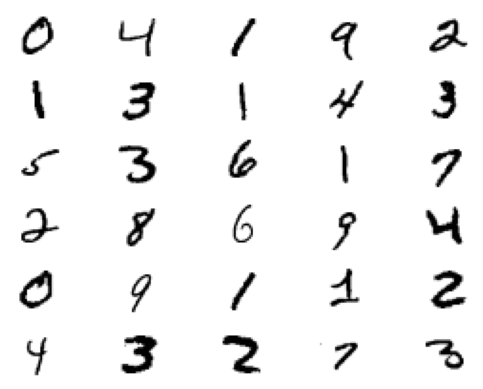

In [30]:
figure = plt.figure()

num_of_images = 30
mnist_images = train_dataset.data.numpy()

for i in range(1, num_of_images + 1):
    plt.subplot(6, 5, i)
    plt.axis('off')
    plt.imshow(mnist_images[i].reshape(28,28), cmap='gray_r')
    
plt.show()

In [11]:
device = "cpu"

# Dimensionalidad del espacio latente
LATENT_DIMS = 2

# Inicializamos el modelo
autoencoder = Autoencoder(LATENT_DIMS).to(device)

optimizer = torch.optim.Adam(params=autoencoder.parameters(), 
                             lr=0.001)

summary(autoencoder)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  401,920
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  131,328
│    │    └─ReLU: 3-4                    --
│    │    └─Linear: 3-5                  32,896
│    │    └─ReLU: 3-6                    --
│    │    └─Linear: 3-7                  258
├─Decoder: 1-2                           --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-8                  384
│    │    └─ReLU: 3-9                    --
│    │    └─Linear: 3-10                 33,024
│    │    └─ReLU: 3-11                   --
│    │    └─Linear: 3-12                 131,584
│    │    └─ReLU: 3-13                   --
│    │    └─Linear: 3-14                 402,192
│    │    └─Sigmoid: 3-15                --
Total params: 1,133,586
Trainable params:

In [12]:
NUM_EPOCHS = 50

# Train model
results = train(model=autoencoder, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                epochs=NUM_EPOCHS,
                verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 72669.727 | test_loss: 52325.522 | 
Epoch: 2 | train_loss: 49315.923 | test_loss: 47963.470 | 
Epoch: 3 | train_loss: 46075.715 | test_loss: 42925.341 | 
Epoch: 4 | train_loss: 41520.671 | test_loss: 40061.950 | 
Epoch: 5 | train_loss: 39106.280 | test_loss: 38170.222 | 
Epoch: 6 | train_loss: 37308.138 | test_loss: 36435.369 | 
Epoch: 7 | train_loss: 35856.883 | test_loss: 35345.672 | 
Epoch: 8 | train_loss: 34770.235 | test_loss: 34358.032 | 
Epoch: 9 | train_loss: 33955.653 | test_loss: 33637.742 | 
Epoch: 10 | train_loss: 33329.471 | test_loss: 33070.347 | 
Epoch: 11 | train_loss: 32815.838 | test_loss: 32830.160 | 
Epoch: 12 | train_loss: 32349.510 | test_loss: 32058.932 | 
Epoch: 13 | train_loss: 31982.760 | test_loss: 31887.644 | 
Epoch: 14 | train_loss: 31630.422 | test_loss: 31533.873 | 
Epoch: 15 | train_loss: 31340.900 | test_loss: 31166.458 | 
Epoch: 16 | train_loss: 31065.695 | test_loss: 30959.605 | 
Epoch: 17 | train_loss: 30775.069 | test_loss: 30

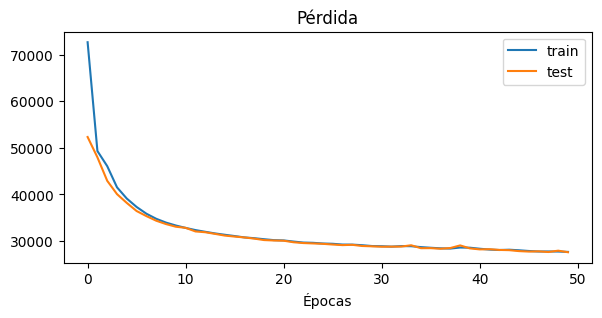

In [13]:
plot_loss_curves(results)

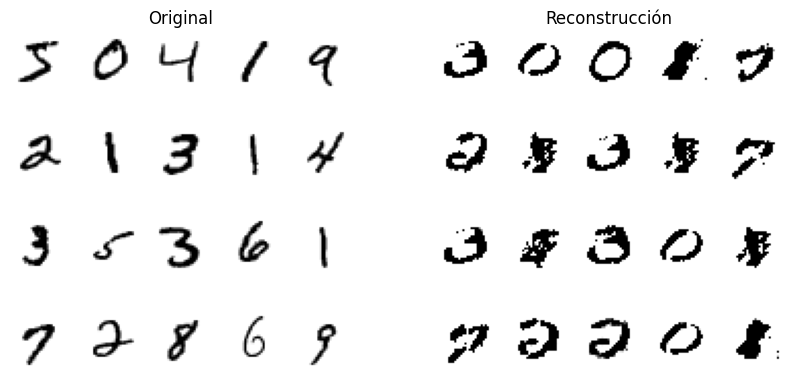

In [14]:
def plot_original_and_reconstructed(n, rows, cols):
    # Código para obtener las imágenes aleatorias
    length_dataset = len(train_dataset.data)
    random_samples = np.random.randint(1, length_dataset, n) 

    # Código para visualizar las imágenes originales y las reconstrucciones
    fig, axs = plt.subplots(rows, 2*cols + 1, figsize=(8, 4))

    # Visualización de imágenes originales
    for idx in range(n): 
        mnist_sample = train_dataset.data[idx].numpy()
        axs[idx // cols, idx % cols].imshow(mnist_sample, cmap='gray_r') 
        axs[idx // cols, idx % cols].axis('off') 

    # Añade el título "Original" a la fila de imágenes originales
    axs[0, cols//2].set_title('Original', loc='center')

    # Visualización de reconstrucciones
    for idx in range(n): 
        x = train_dataset.data[idx].unsqueeze(0).to(torch.float32)
        z = autoencoder.encoder(x.to(device))
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()

        axs[idx // cols, idx % cols + cols + 1].imshow(x_hat, cmap='gray_r') 
        axs[idx // cols, idx % cols + cols + 1].axis('off') 

    # Elimino los ejes de la grilla del medio
    for row in range(rows):
        axs[row , (2*cols + 1) //2].axis('off') 
    
    # Añade el título "Reconstrucción" a la fila de imágenes reconstruidas
    axs[0, (cols + 2*cols)//2 + 1].set_title('Reconstrucción', loc='center')
    
    plt.tight_layout() 
    plt.show()

# Uso del método con n=20, 4 filas y 5 columnas
plot_original_and_reconstructed(n=20, rows=4, cols=5)


## 1.4 Espacio Latente y Visualización

El **espacio latente** es el espacio de representación de dimensionalidad reducida en el que los datos son mapeados por el codificador. Esta representación contiene las características más relevantes y distintivas de los datos originales.

### Importancia del Espacio Latente

- **Compactación de Información**: El espacio latente permite una representación más compacta y eficiente de los datos, lo que facilita su almacenamiento y procesamiento.

- **Extracción de Características**: Al aprender a representar los datos de manera efectiva, el espacio latente puede capturar características importantes que son útiles para tareas posteriores como clasificación o detección de anomalías.

- **Generalización**: El espacio latente debería ser lo suficientemente general como para representar diferentes variaciones de los datos, permitiendo así la generación de nuevas muestras que sean coherentes con el conjunto de datos original.

In [31]:
def plot_latent(autoencoder, data, num_batches=100):
    """
    Visualiza el espacio latente de un autoencoder.

    Parámetros:
        - autoencoder (nn.Module): El modelo del autoencoder.
        - data (torch.utils.data.DataLoader): Conjunto de datos de entrenamiento.
        - num_batches (int, opcional): Número de lotes a visualizar. Default es 100.
    """
    for i, (x, y) in enumerate(data):
        # Ejecución del modelo E2E
        z = autoencoder.encoder(x.to(device))

        # Convertimos a array de numpy para poder manipularlos con la librería matplotlib
        z = z.to('cpu').detach().numpy()
        
        plt.title("Espacio Latente")
        plt.scatter(z[:, 0], z[:, 1], s=1, c=y, cmap='tab10')

    plt.colorbar()

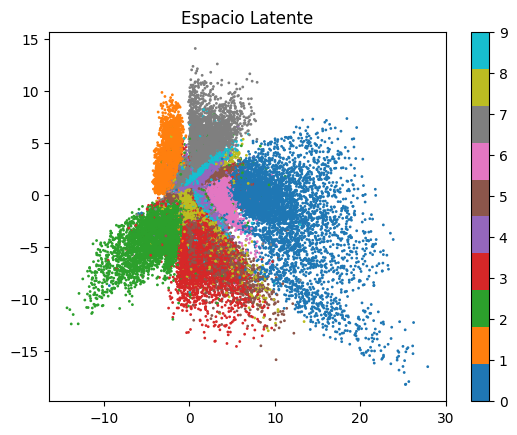

In [16]:
plot_latent(autoencoder, test_dataloader)

In [32]:
def plot_reconstructed(autoencoder, r0=(-300, 600), r1=(-300, 500), n=12):
    """
    Visualiza la reconstrucción de imágenes a partir del espacio latente.

    Parámetros:
        - autoencoder (nn.Module): El modelo del autoencoder.
        - r0 (tuple, opcional): Rango de valores para la dimensión 0 del espacio latente. Default es (-5, 10).
        - r1 (tuple, opcional): Rango de valores para la dimensión 1 del espacio latente. Default es (-10, 5).
        - n (int, opcional): Número de imágenes a visualizar en cada dimensión. Default es 12.
    """
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
            
    plt.title("Datos de Entrada en el Espacio Latente")
    plt.imshow(img, extent=[*r0, *r1], cmap="gray_r", aspect="auto")


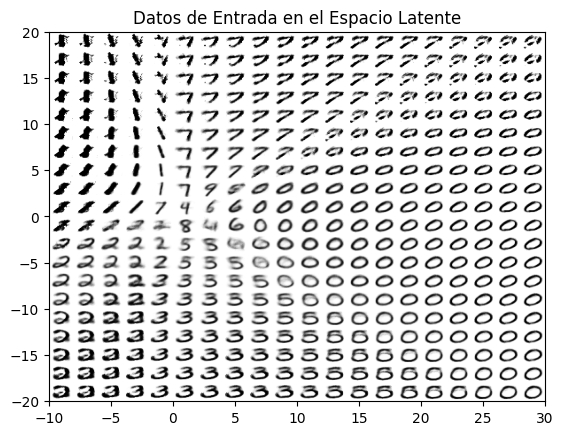

In [19]:
plot_reconstructed(autoencoder, r0=(-10, 30), r1=(-20, 20), n=20)

## Ejercicios

1. Mejore la performance del autoencoder. Puede aumentar las capas, variar los hiperparámetros, incluir regularización, aumentar la dimensionalidad del espacio latente, etc
2. ¿Qué sucede si se eliminan todas las funciones de activación de la red? ¿Cómo luce el espacio latente?
3. Implmente un detector de anomalías. Utilice el error de reconstrucción e inspeccione como se distribuye éste para cada clase. Concentrese en una clase en particular y responda las siguientes preguntas:
   * ¿Qué caracteísticas poseen los digitos que poseen un error de reconstrucción cercano a la media de la distribución?
   * ¿Qué carácterisiticas poseen los digitos que se encuentran en los extremos?
   * ¿En qué se diferencian unos de otros?
4. Implemente un "Denoising autoencoder", este modelo permite limpiar el ruido de una imagen de entrada. Para ello deberá corromper las imagenes de entrada con un ruido gaussiano y luego entrenar un Autoencoder para intentar reproducir la imagen sin corromper.

## 2.0 Autoencoder Variacional (VAE)

### El Problema Variacional

El VAE aborda el problema de aprendizaje generativo desde una perspectiva probabilística. 
Supongamos que tenemos un conjunto de datos de entrenamiento $X$. El objetivo es encontrar el mejor modelo generativo que maximiza la probabilidad de los datos de entrenamiento $p(X)$. Sin embargo, calcular directamente $p(X)$, que por lo general es una integral intratable.

En su lugar, se introduce un **problema variacional**. Se plantea un modelo generativo parametrizado, que mapea datos de entrada $X$ a una distribución en el espacio latente $Z$. Para entrenar este modelo, se maximiza una cota inferior de la verosimilitud de los datos:

$\mathcal{L}(X) \leq \log p(X)$

Un autoencoder variacional, al igual que su contraparte tradicional, consta de dos partes principales: 
1. El codificador (encoder)
2. El decodificador (decoder)

<img src="imagenes/vae.png" width="80%"/> 


### 2.1 Costrucción del Codificador (Inferencia Variacional)

El codificador mapea $X$ a dos vectores, la media $\mu$ y la desviación estándar $\sigma$ de una distribución gaussiana en el espacio latente $Z$. 
Esto se logra mediante capas completamente conectadas que reducen gradualmente la dimensionalidad de $X$.

- $\mu = f_{\mu}(X)$
- $\log \sigma^2 = f_{\sigma^2}(X)$

#### Muestreo de $Z$

Dado $\mu$ y $\sigma$, se utiliza el truco de reparametrización para muestrear $z$ de $p(Z|X)$:


$z = \mu + \sigma \cdot \epsilon, \quad \text{donde } \epsilon \sim \mathcal{N}(0,1)$

In [33]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    """
    Clase que define el codificador de un autoencoder variacional (VAE).

    Parámetros:
        - latent_dims (int): Número de dimensiones en el espacio latente.

    Atributos:
        - encode (nn.Sequential): Capas de codificación.
        - mu (nn.Linear): Capa lineal para la media de la distribución en el espacio latente.
        - sigma (nn.Linear): Capa lineal para la desviación estándar de la distribución en el espacio latente.
        - N (torch.distributions.Normal): Distribución normal para el muestreo estocástico.
        - kl (float): Valor de la divergencia de Kullback-Leibler (KL).

    Métodos:
        - forward(x): Realiza la pasada hacia adelante de la red.

    """

    def __init__(self, latent_dims):
        """
        Inicializa las capas del codificador.

        Parámetros:
            - latent_dims (int): Número de dimensiones en el espacio latente.
        """
        super(Encoder, self).__init__()

        # Capas de codificación
        self.encode = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Capa lineal para la media de la distribución en el espacio latente
        self.mu = nn.Linear(128, latent_dims)

        # Capa lineal para la desviación estándar de la distribución en el espacio latente
        self.sigma = nn.Linear(128, latent_dims)

        # Distribución normal para el muestreo estocástico
        self.N = torch.distributions.Normal(0, 1)

        # Inicialización del valor de la divergencia de Kullback-Leibler (KL)
        self.kl = 0

    def forward(self, x):
        """
        Realiza una pasada hacia adelante a través del codificador.

        Parámetros:
            - x (torch.Tensor): Tensor de entrada.

        Returns:
            - torch.Tensor: Tensor resultante después de la codificación.
        """
        # Aplanamos la imagen de entrada
        x = torch.flatten(x, start_dim=1)

        # Capas de codificación
        x = self.encode(x)
        
        # Calculamos la media y la desviación estándar en el espacio latente
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x))
        
        # Muestreo estocástico en el espacio latente
        z = mu + sigma * self.N.sample(mu.shape)
        
        # Cálculo de la divergencia de Kullback-Leibler (KL)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z



### 2.2 Construcción del Decodificador (Generador)

El decodificador toma una muestra de $Z$ y la mapea de regreso a la dimensionalidad original de los datos.

- $X' = g(Z)$

In [34]:
import torch.nn as nn

class Decoder(nn.Module):
    """
    Clase que define el decodificador de un autoencoder variacional (VAE).

    Parámetros:
        - latent_dims (int): Número de dimensiones en el espacio latente.

    Atributos:
        - decode (nn.Sequential): Capas de decodificación.

    Métodos:
        - forward(z): Realiza la pasada hacia adelante de la red.

    """

    def __init__(self, latent_dims):
        """
        Inicializa las capas del decodificador.

        Parámetros:
            - latent_dims (int): Número de dimensiones en el espacio latente.
        """
        super(Decoder, self).__init__()

        # Capas de decodificación
        self.decode = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        """
        Realiza una pasada hacia adelante a través del decodificador.

        Parámetros:
            - z (torch.Tensor): Tensor de representaciones latentes.

        Returns:
            - torch.Tensor: Tensor resultante después de la reconstrucción.
        """
        z = self.decode(z)
        return z.reshape((-1, 1, 28, 28))



In [35]:
import torch.nn as nn

class VariationalAutoencoder(nn.Module):
    """
    Clase que define un autoencoder variacional (VAE).

    Parámetros:
        - latent_dims (int): Número de dimensiones en el espacio latente.

    Atributos:
        - encoder (Encoder): Componente de codificación.
        - decoder (Decoder): Componente de decodificación.

    Métodos:
        - forward(x): Realiza la pasada hacia adelante de la red.

    """

    def __init__(self, latent_dims):
        """
        Inicializa un autoencoder variacional (VAE) con un codificador y decodificador.

        Parámetros:
            - latent_dims (int): Número de dimensiones en el espacio latente.
        """
        super(VariationalAutoencoder, self).__init__()
        
        # Inicializamos las dos componentes: codificador y decodificador
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        """
        Realiza una pasada hacia adelante a través del autoencoder variacional (VAE).

        Parámetros:
            - x (torch.Tensor): Tensor de entrada.

        Returns:
            - torch.Tensor: Tensor resultante después de la reconstrucción.
        """
        z = self.encoder(x)
        return self.decoder(z)



### 2.2 Función de Costo

La función de pérdida del VAE consiste en dos términos:

1. **Error de Reconstrucción (Reconstruction Loss)**:
   - Mide la discrepancia entre los datos originales y la reconstrucción producida por el decodificador.
   - Para datos binarios, se utiliza la pérdida de entropía cruzada binaria. Para datos continuos, se emplea la pérdida cuadrática media.

$\text{Reconstruction Loss} = - \sum_{i=1}^{N} \log p(X_i|z_i)$

2. **Divergencia KL (KL Divergence)**:
   - Cuantifica la diferencia entre la distribución en el espacio latente y una distribución normal estándar. 
   - Fuerza al espacio latente a seguir una distribución cercana a una normal estándar.

$\text{KL Divergence} = - \frac{1}{2} \sum_{i=1}^{N} \left(1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2\right)$


#### LaFunción de Pérdida Completa

La función de pérdida total es la combinación de la pérdida de reconstrucción y la divergencia KL, ponderada por un factor \(\beta\):

$\mathcal{L} = \text{Reconstruction Loss} + \beta \cdot \text{KL Divergence}$

Donde $\beta$ es un hiperparámetro que controla la importancia relativa entre los términos de reconstrucción y regularización. Por defecto suele ser 1.


In [36]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer,
               beta: float):
    """
    Realiza un paso de entrenamiento para un modelo de autoencoder variacional (VAE).

    Parámetros:
        - model (torch.nn.Module): El modelo a entrenar.
        - dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de entrenamiento.
        - optimizer (torch.optim.Optimizer): Optimizador para el modelo.
        - alpha (float): Peso del término de regularización KL.

    Returns:
        - float: Pérdida promedio en el conjunto de datos de entrenamiento.
    """
    # Coloca el modelo en modo de entrenamiento
    model.train()
    
    # Inicializa la pérdida de entrenamiento
    train_loss = 0
    
    # Itera a través de los lotes de datos en el DataLoader
    for batch, data in enumerate(dataloader):

        # Envía los datos al dispositivo objetivo
        image = data[0]
        x = image.to(device)

        # 1. Realiza el pase hacia adelante
        x_hat = model(x)

        # 2. Calcula y acumula la pérdida
        loss = ((x - x_hat)**2).sum() + beta * model.encoder.kl
        train_loss += loss.item()

        # 3. Reinicia los gradientes del optimizador
        optimizer.zero_grad()

        # 4. Retropropagación de la pérdida
        loss.backward()

        # 5. Actualiza los pesos del modelo
        optimizer.step()

    # Ajusta las métricas para obtener la pérdida promedio por lote 
    train_loss = train_loss / len(dataloader)
    return train_loss


In [37]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              beta: float):
    """
    Realiza un paso de evaluación para un modelo de autoencoder variacional (VAE).

    Parámetros:
        - model (torch.nn.Module): El modelo a evaluar.
        - dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de prueba.
        - alpha (float): Peso del término de regularización KL.

    Returns:
        - float: Pérdida promedio en el conjunto de datos de prueba.
    """
    # Pone el modelo en modo de evaluación
    model.eval() 
    
    # Inicializa la pérdida de prueba
    test_loss= 0
    
    # Activa el contexto de inferencia
    with torch.inference_mode():
        
        # Itera a través de los lotes de datos en el DataLoader
        for batch, data in enumerate(dataloader):
            
            # Envía los datos al dispositivo objetivo
            image = data[0]
            x = image.to(device)
        
            # 1. Realiza el pase hacia adelante
            x_hat = model(x)
        
            # 2. Calcula y acumula la pérdida
            loss = ((x - x_hat)**2).sum() + beta * model.encoder.kl
            test_loss += loss.item()
            
    # Ajusta las métricas para obtener la pérdida promedio por lote 
    test_loss = test_loss / len(dataloader)
    return test_loss


In [38]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          beta: float=1.0, 
          verbose=False):
    """
    Entrena un modelo de autoencoder variacional (VAE) durante un número especificado de épocas.

    Parámetros:
        - model (torch.nn.Module): El modelo a entrenar.
        - train_dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de entrenamiento.
        - test_dataloader (torch.utils.data.DataLoader): DataLoader con el conjunto de datos de prueba.
        - optimizer (torch.optim.Optimizer): Optimizador para el modelo.
        - epochs (int, opcional): Número de épocas de entrenamiento. Default es 5.
        - alpha (float, opcional): Peso del término de regularización KL. Default es 1.0.
        - verbose (bool, opcional): Si True, imprime información sobre el progreso del entrenamiento. Default es False.

    Returns:
        - dict: Diccionario con las pérdidas de entrenamiento y prueba en cada época.
    """
    # Crea un diccionario de resultados vacío
    results = {"train_loss": [],
               "test_loss": [],
              }
    
    # Itera a través de los pasos de entrenamiento y prueba durante un número de épocas
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                optimizer=optimizer,
                                beta=beta)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              beta=beta)
        
        # Imprime información sobre el progreso del entrenamiento
        if verbose:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.3f} | "
                f"test_loss: {test_loss:.3f} | "
            )

        # Actualiza el diccionario de resultados
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Devuelve el diccionario de resultados lleno al final de las épocas
    return results


In [39]:
# Definimos el dispositivo de ejecución
device = "cpu"

# Dimensionalidad del espacio latente
LATENT_DIMS = 2

# Inicializamos el modelo VAE con 2 dimensiones en el espacio latente y lo movemos al dispositivo
vae = VariationalAutoencoder(LATENT_DIMS).to(device)

# Inicializamos un optimizador Adam para el modelo VAE
optimizer = torch.optim.Adam(params=vae.parameters(), 
                             lr=0.001, 
                             weight_decay=0.001)

# Mostramos un resumen del modelo
summary(vae)

Layer (type:depth-idx)                   Param #
VariationalAutoencoder                   --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  401,920
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  131,328
│    │    └─ReLU: 3-4                    --
│    │    └─Linear: 3-5                  32,896
│    │    └─ReLU: 3-6                    --
│    └─Linear: 2-2                       258
│    └─Linear: 2-3                       258
├─Decoder: 1-2                           --
│    └─Sequential: 2-4                   --
│    │    └─Linear: 3-7                  384
│    │    └─ReLU: 3-8                    --
│    │    └─Linear: 3-9                  33,024
│    │    └─ReLU: 3-10                   --
│    │    └─Linear: 3-11                 131,584
│    │    └─ReLU: 3-12                   --
│    │    └─Linear: 3-13                 402,192
│    │    └─Sigmoid: 3-14               

In [40]:
# Número de épocas de entrenamiento
NUM_EPOCHS = 50

# Entrena el modelo
results = train(model=vae, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                epochs=NUM_EPOCHS,
                verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 70506.821 | test_loss: 55010.973 | 
Epoch: 2 | train_loss: 53862.806 | test_loss: 52010.353 | 
Epoch: 3 | train_loss: 50805.100 | test_loss: 49738.572 | 
Epoch: 4 | train_loss: 49297.009 | test_loss: 48890.138 | 
Epoch: 5 | train_loss: 47581.078 | test_loss: 46512.375 | 
Epoch: 6 | train_loss: 45586.937 | test_loss: 44641.498 | 
Epoch: 7 | train_loss: 43892.592 | test_loss: 43259.335 | 
Epoch: 8 | train_loss: 42867.289 | test_loss: 42503.816 | 
Epoch: 9 | train_loss: 42135.936 | test_loss: 41807.168 | 
Epoch: 10 | train_loss: 41517.908 | test_loss: 41135.910 | 
Epoch: 11 | train_loss: 40906.744 | test_loss: 40629.183 | 
Epoch: 12 | train_loss: 40402.995 | test_loss: 40255.533 | 
Epoch: 13 | train_loss: 39971.490 | test_loss: 39811.407 | 
Epoch: 14 | train_loss: 39633.032 | test_loss: 39536.431 | 
Epoch: 15 | train_loss: 39336.959 | test_loss: 39155.269 | 
Epoch: 16 | train_loss: 39013.211 | test_loss: 38887.473 | 
Epoch: 17 | train_loss: 38714.321 | test_loss: 38

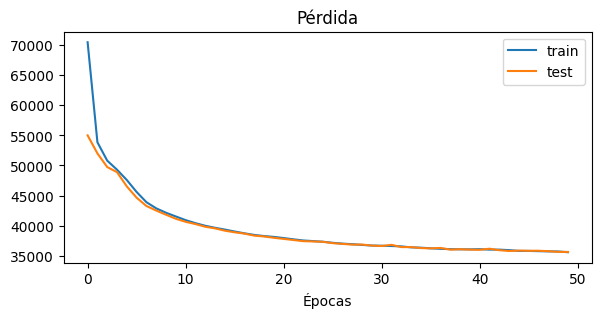

In [41]:
plot_loss_curves(results)

In [42]:
def decode_sample(x, sample_size=1):
    """Genera muestras a partir de un tensor de entrada usando el VAE.

    Args:
        x (torch.Tensor): Tensor de entrada que representa una imagen.
            Debe tener la forma (batch_size, channels, height, width).
        sample_size (int, optional): Número de muestras a generar. Por defecto es 1.

    Returns:
        numpy.ndarray: Arreglo que contiene las muestras generadas.

    Raises:
        ValueError: Si el tensor de entrada no tiene la forma esperada.

    Notes:
        - El modelo VAE (`vae`) debe estar definido y accesible en el ámbito donde se utiliza esta función.
    """
    # Aplanamos la imagen de entrada
    x = torch.flatten(x, start_dim=1)
    
    # Codificación y muestreo en el espacio latente
    x = vae.encoder.encode(x)
    mu =  vae.encoder.mu(x)
    sigma = torch.exp(vae.encoder.sigma(x))

    q = torch.distributions.Normal(mu, sigma)
    z = q.rsample(sample_shape=[sample_size])
    
    # Decodificación de las muestras latentes
    x_hat = vae.decoder(z)

    return x_hat.detach().numpy()


In [43]:
def plot_sample(vae_sample, rows, cols):
    """Visualiza un conjunto de muestras generadas por un VAE en una cuadrícula.

    Args:
        vae_sample (numpy.ndarray): Conjunto de muestras generado por el VAE. 
            Debe ser un arreglo numpy de shape (n_samples, height, width), donde 
            height y width son las dimensiones de las imágenes.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None

    Displays:
        Una cuadrícula de imágenes generadas por el VAE.
    """
    sample_size = vae_sample.shape[0]
    
    fig, axs = plt.subplots(rows, cols, figsize=(8, 4))
    
    # Visualización de imágenes generadas por el VAE
    for idx in range(sample_size): 
        image = vae_sample[idx][0]
        axs[idx // cols, idx % cols].imshow(image, cmap='gray_r') 
        axs[idx // cols, idx % cols].axis('off') 
    
    plt.suptitle("Imágenes Generadas por el VAE")
    plt.show()


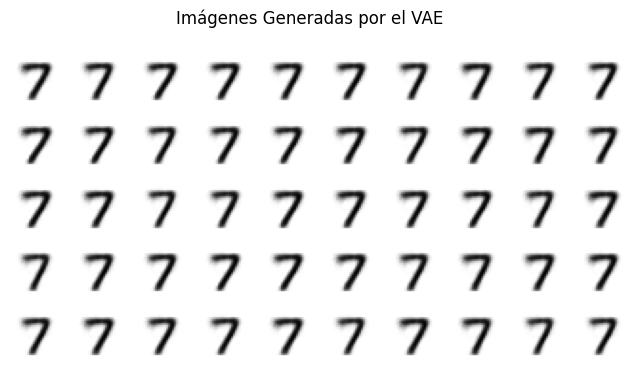

In [44]:
# Selecciona un lote de datos
x, y = next(iter(train_dataloader))

# Busca una imagen de un 5
x_3 = x[y == 7][36].to(device)

# Genera una muestra partiendo de una imagen 
vae_samples = decode_sample(x_3, sample_size=50)

# Visualiza las imagenes generadas por el VAE
plot_sample(vae_samples, 5, 10)

### 2.3 Espacio Latente Continuo


El espacio latente del VAE está diseñado para ser continuo y estructurado. Esto significa que las transiciones suaves en el espacio latente se traducen en transiciones suaves en la representación original. 

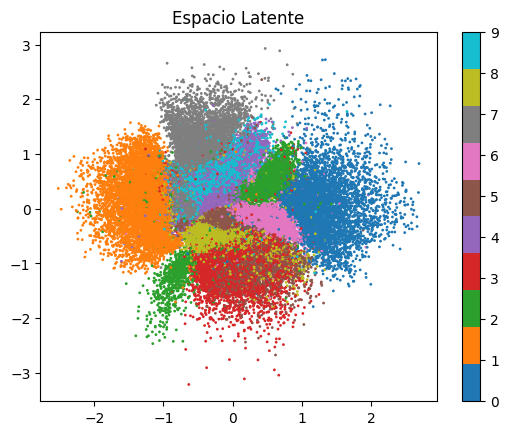

In [45]:
plot_latent(vae, train_dataloader)

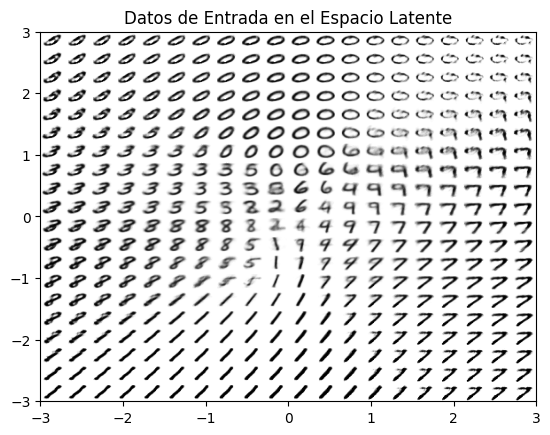

In [39]:
border = 3
plot_reconstructed(vae, r0=(-border, border), r1=(-border, border), n=20)

In [46]:
def interpolate(autoencoder, x_1, x_2, n=12):
    """
    Realiza una interpolación en el espacio latente entre dos imágenes y visualiza la transición.

    Parámetros:
        - autoencoder: El modelo de autoencoder.
        - x_1: Primera imagen de entrada.
        - x_2: Segunda imagen de entrada.
        - n (int, opcional): Número de pasos en la interpolación. Default es 12.
    """
    # Obtener las representaciones latentes de las dos imágenes
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    # Realizar la interpolación en el espacio latente
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    # Decodificar las representaciones latentes interpoladas
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to(device).detach().numpy()

    # Construir la imagen final
    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)

    # Mostrar la imagen interpolada
    plt.figure(figsize=(25,3))
    plt.imshow(img, cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


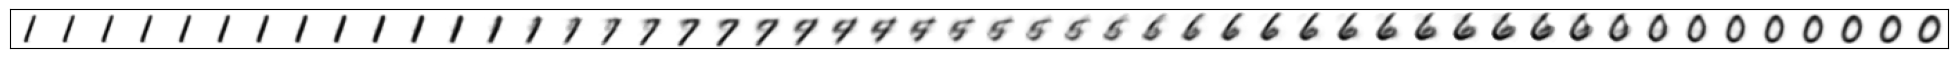

In [53]:
# Selecciono un lote de datos
x, y = next(iter(train_dataloader))

# Busco una imagen de un 1
x_1 = x[y == 1][0].to(device)

# Busco una imagen de un 0
x_2 = x[y == 0][0].to(device)

interpolate(vae, x_1, x_2, n=50)

## Ejercicios
1.  Varie el valor del parametro beta, ¿Cómo impacta en el espacio latente y en la reconstrucción? ¿Qué sucede en los casos límite, para valores cercanos a 0 y para valores mayores a 1?
2.  Construya un codigo que permita aumentar el valor de beta suavemente en el entrenamiento hasta alcanzar un cierto valor (puede ser 1), o también un codigo que luego de cierta cantidad de iteraciones lo "prenda" abruptamente. ¿Mejora los resultados obtenidos? ¿Cómo impacta en el espacio latente?

In [247]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import List
from torch.distributions.multivariate_normal import MultivariateNormal
import math
from torch.nn import BCEWithLogitsLoss

ACTIVATION_DERIVATIVES = {
    F.elu: lambda x: torch.ones_like(x) * (x >= 0) + torch.exp(x) * (x < 0),
    torch.tanh: lambda x: 1 - torch.tanh(x) ** 2
}

class PlanarFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]

        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)

    def forward(self, z: torch.Tensor):
        lin = (z @ self.w + self.b).unsqueeze(1)  # shape: (B, 1)
        f = z + self.u * self.activation(lin)  # shape: (B, D)
        phi = self.activation_derivative(lin) * self.w  # shape: (B, D)
        log_det = torch.log(torch.abs(1 + phi @ self.u)) # shape: (B,)
        

        return f, log_det

class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

        
    def forward(self, x):
        return self.net(x)


class FlowModel(nn.Module):
    def __init__(self, flows: List[str], D: int, activation=torch.tanh):
        super().__init__()
        
        self.prior = MultivariateNormal(torch.zeros(D), torch.eye(D))
        self.net = []

        for i in range(len(flows)):
            layer_class = eval(flows[i])
            self.net.append(layer_class(D, activation))

        self.net = nn.Sequential(*self.net)

        self.D = D


    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor):
        """
        mu: tensor with shape (batch_size, D)
        sigma: tensor with shape (batch_size, D)
        """
        sigma = torch.exp(log_sigma)
        batch_size = mu.shape[0]
        samples = self.prior.sample(torch.Size([batch_size]))
        z = samples * sigma + mu

        z0 = z.clone().detach()
        log_prob_z0 = torch.sum(
            -0.5 * torch.log(torch.tensor(2 * math.pi)) - 
            log_sigma - 0.5 * ((z - mu) / sigma) ** 2, 
            axis=1)
        
        log_det = torch.zeros((batch_size,))
        
        for layer in self.net:
            z, ld = layer(z)
            log_det += ld

        # log_prob_zk = self.prior.log_prob(z)
        log_prob_zk = torch.sum(
            -0.5 * (torch.log(torch.tensor(2 * math.pi)) + z ** 2), 
            axis=1)

        return z, log_prob_z0, log_prob_zk, log_det


class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

In [248]:
class BinaryMNIST():
    def __init__(self, mnist_data):
        self.images, self.labels = mnist_data.data, mnist_data.targets
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image[image < 127] = 0
        image[image >= 127] = 255
        return image, label

# Descarga las imágenes del MNIST
train_dataset = torchvision.datasets.MNIST(
    './data',
    transform=None,  # No se aplica ninguna transformación por ahora
    download=True,
    train=True
)

# Aplica el transformador BinaryMNIST
binary_train_dataset = BinaryMNIST(train_dataset)

# Cargar los datos usando un DataLoader
data_loader = torch.utils.data.DataLoader(
    binary_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)


In [249]:
D = 40

encoder = FCNEncoder(hidden_sizes=[512, 256, 128, 2*D], dim_input=28*28)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=D)
decoder = FCNDecoder(hidden_sizes=[128, 256, 512, 784], dim_input=D)

loss_fn = BCEWithLogitsLoss()
NUM_EPOCHS = 50

train_loss = 0

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))


for epoch in range(NUM_EPOCHS):
    
    for batch, X_batch in enumerate(data_loader):
        
        x = X_batch[0]
        
        x = torch.flatten(x, start_dim=1)
        x = torch.where(x > 0, 1, 0)
        
        out = encoder(x.float())
        
        mu, log_sigma = out[:, :D], out[:, D:]
        
        z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
        
        x_hat = decoder(z_k)
        # x_hat = (x_hat > 0).float()

        loss = torch.mean(log_prob_z0) + loss_fn(x_hat, x.float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
        
        train_loss += loss.item()

        # 3. Reinicia los gradientes del optimizador
        optimizer.zero_grad()

        # 4. Retropropagación de la pérdida
        loss.backward()

        # 5. Actualiza los pesos del modelo
        optimizer.step()
        
    train_loss = train_loss / len(train_dataloader)
    
    print(f'Iteration {epoch}, loss: {train_loss}')


Iteration 0, loss: 1991.5050405405336
Iteration 1, loss: 166.65084848993644
Iteration 2, loss: 59.79920259643302
Iteration 3, loss: 49.086294489985924
Iteration 4, loss: 32.47369292459054
Iteration 5, loss: 39.328445127973644
Iteration 6, loss: 27.19244627816815
Iteration 7, loss: 25.96425701882599
Iteration 8, loss: 24.01325555199724
Iteration 9, loss: 23.721146475722282
Iteration 10, loss: 23.65690638068453
Iteration 11, loss: 23.478594257912924
Iteration 12, loss: 24.03871199967635
Iteration 13, loss: 23.729396013466342
Iteration 14, loss: 23.321340933156684
Iteration 15, loss: 23.287077849441875
Iteration 16, loss: 23.27362620233368
Iteration 17, loss: 23.286095261472575
Iteration 18, loss: 23.26831147933239
Iteration 19, loss: 23.277067689212743
Iteration 20, loss: 23.192345080202458
Iteration 21, loss: 23.196386616570557
Iteration 22, loss: 23.25264567003989
Iteration 23, loss: 23.374419854836667
Iteration 24, loss: 23.18487627504163
Iteration 25, loss: 23.222759507671906
Iterati

KeyboardInterrupt: 

In [261]:
def decode_sample(x, sample_size=1):
    """Genera muestras a partir de un tensor de entrada usando el VAE.

    Args:
        x (torch.Tensor): Tensor de entrada que representa una imagen.
            Debe tener la forma (batch_size, channels, height, width).
        sample_size (int, optional): Número de muestras a generar. Por defecto es 1.

    Returns:
        numpy.ndarray: Arreglo que contiene las muestras generadas.

    Raises:
        ValueError: Si el tensor de entrada no tiene la forma esperada.

    Notes:
        - El modelo VAE (`vae`) debe estar definido y accesible en el ámbito donde se utiliza esta función.
    """        
    x = torch.flatten(x, start_dim=1)
    
    out = encoder(x.float())
    
    mu, log_sigma = out[:, :D], out[:, D:]
    
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    
    x_hat = decoder(z_k).reshape((-1, 1, 28, 28))[0]

    return x_hat.detach().numpy()


In [255]:
def plot_sample(nf_sample, rows, cols):
    """Visualiza un conjunto de muestras generadas por un VAE en una cuadrícula.

    Args:
        vae_sample (numpy.ndarray): Conjunto de muestras generado por el VAE. 
            Debe ser un arreglo numpy de shape (n_samples, height, width), donde 
            height y width son las dimensiones de las imágenes.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None

    Displays:
        Una cuadrícula de imágenes generadas por el VAE.
    """
    sample_size = nf_sample.shape[0]
    print(sample_size)
    fig, axs = plt.subplots(rows, cols, figsize=(8, 4))
    
    # Visualización de imágenes generadas por el VAE
    for idx in range(sample_size): 
        image = nf_sample[idx].reshape((-1, 1, 28, 28))[0]
        axs[idx // cols, idx % cols].imshow(image, cmap='gray_r') 
        axs[idx // cols, idx % cols].axis('off') 
    
    plt.suptitle("Imágenes Generadas por el VAE")
    plt.show()


In [256]:
# Selecciona un lote de datos
x, y = next(iter(data_loader))

x.shape

torch.Size([32, 28, 28])

In [264]:
# Selecciona un lote de datos
x, y = next(iter(data_loader))

# Busca una imagen de un 5
x_3 = x[y == 3].to(device)

# Genera una muestra partiendo de una imagen 
nf_samples = decode_sample(x)

TypeError: Invalid shape (28,) for image data

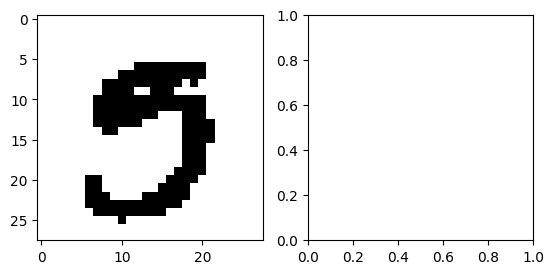

In [265]:
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.imshow(x_sample, cmap="gray_r")

plt.subplot(1,2,2)
plt.imshow(nf_samples[0][0], cmap="gray_r")

plt.show()